In [37]:
import torch
import torch.nn as nn
import torch.optim as optim

In [38]:
import numpy as np

In [39]:
import sys
sys.path.append('peptide-QML/')

from my_code import functions as f

# Data

In [40]:
file_path = 'peptide-QML/data/energies/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(file_path)
score_list = np.array(number_list)/100
vector_list = np.array([f.string_to_vector(string) for string in string_list]) # one hot encoding

In [41]:
n_aminoacids = len(string_list[0])

In [42]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [43]:
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]) # flatten
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1]*X_validation.shape[2]) # flatten

In [44]:
# Define the dataset
input_data = torch.tensor(X, dtype=torch.float32)
target_data = torch.tensor(Y, dtype=torch.float32).view(-1, 1)

# Define the validation set
input_validation = torch.tensor(X_validation, dtype=torch.float32)
target_validation = torch.tensor(Y_validation, dtype=torch.float32).view(-1, 1)

# Classical model

In [45]:
input_dim = input_data.size(1)

In [46]:
n_pre_classical_layers = 4
layers_dim = np.linspace(4, input_dim, 4).astype(int)

In [47]:
layers = []
for i in range(1, len(layers_dim)):
    layers += [nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), nn.ReLU()]
layers += [nn.Linear(layers_dim[0], layers_dim[0])]
layers += [nn.Linear(layers_dim[0], 1)]


Net = nn.Sequential(*layers)

In [48]:
# Create an instance of the network
model = Net

In [49]:
import time

In [50]:
# time
start_time = time.time()


# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.05)  # Adam optimizer with learning rate 0.001
# optimizer = optim.SGD(model.parameters(), lr=0.05)

# Training loop
num_epochs = 25
batch_size = 32

#validation data
i_validation = input_validation[::10] #we take only 10% of the validation data, to speed up the process
t_validation = target_validation[::10] 

losses = []
losses_epochs = [0]
losses_epochs_validation = [0]

losses_epochs[-1] = criterion(model(input_data), target_data).item()
losses_epochs_validation[-1] = criterion(model(i_validation), t_validation).item()
print('Epoch [{}/{}], Loss: {:.4f}, Loss validation: {:.4f}'.format(0, num_epochs, losses_epochs[-1], losses_epochs_validation[-1]))

for epoch in range(num_epochs):
    # Shuffle the dataset
    indices = torch.randperm(input_data.size(0))
    input_data = input_data[indices]
    target_data = target_data[indices]

    losses_epochs.append(0)

    # Mini-batch training
    for i in range(0, input_data.size(0), batch_size):
        inputs = input_data[i:i+batch_size]
        targets = target_data[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss
        losses.append(loss.item())

        print('- Epoch [{}/{}], i: [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, input_data.size(0), loss.item()), end='\r')

        # add to the epoch loss
        losses_epochs[-1] += loss.item() 

    # divide the epoch loss by the number of batches, to get the average loss
    losses_epochs[-1] /= (input_data.size(0)/batch_size)

    # Validation
    losses_epochs_validation.append(criterion(model(i_validation), t_validation).item())    

    # time
    # Compute elapsed time and remaining time
    elapsed_time = time.time() - start_time
    avg_time_per_epoch = elapsed_time / (epoch + 1)
    remaining_epochs = num_epochs - (epoch + 1)
    estimated_remaining_time = avg_time_per_epoch * remaining_epochs

    # Convert remaining time to hours, minutes, and seconds for better readability
    hours, remainder = divmod(estimated_remaining_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    # Print the loss and remaining time for this epoch
    print('Epoch [{}/{}], Loss: {:.4f}, Loss validation: {:.4f}, Time remaining: ~{}h {}m {:.0f}s'.format(
        epoch+1, num_epochs, losses_epochs[-1], losses_epochs_validation[-1], hours, minutes, seconds))


Epoch [0/25], Loss: 2.0451, Loss validation: 2.9102


Epoch [1/25], Loss: 0.1812, Loss validation: 0.0773, Time remaining: ~0.0h 0.0m 11s
Epoch [2/25], Loss: 0.0435, Loss validation: 0.0455, Time remaining: ~0.0h 0.0m 9s
Epoch [3/25], Loss: 0.0136, Loss validation: 0.0143, Time remaining: ~0.0h 0.0m 8s
Epoch [4/25], Loss: 0.0119, Loss validation: 0.0058, Time remaining: ~0.0h 0.0m 8s
Epoch [5/25], Loss: 0.0140, Loss validation: 0.0228, Time remaining: ~0.0h 0.0m 7s
Epoch [6/25], Loss: 0.0129, Loss validation: 0.0100, Time remaining: ~0.0h 0.0m 7s
Epoch [7/25], Loss: 0.0171, Loss validation: 0.2052, Time remaining: ~0.0h 0.0m 6s
Epoch [8/25], Loss: 0.0756, Loss validation: 0.0253, Time remaining: ~0.0h 0.0m 6s
Epoch [9/25], Loss: 0.0150, Loss validation: 0.0114, Time remaining: ~0.0h 0.0m 5s
Epoch [10/25], Loss: 0.0074, Loss validation: 0.0092, Time remaining: ~0.0h 0.0m 5s
Epoch [11/25], Loss: 0.0055, Loss validation: 0.0072, Time remaining: ~0.0h 0.0m 5s
Epoch [12/25], Loss: 0.0085, Loss validation: 0.0084, Time remaining: ~0.0h 0.0m 4s


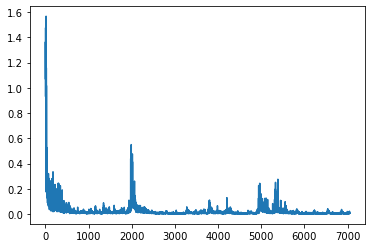

In [51]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

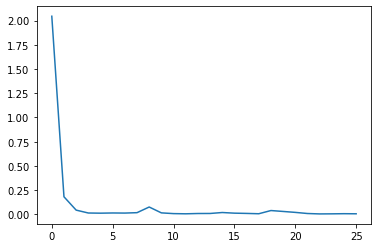

In [52]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses_epochs)
plt.show()

In [53]:
avg_loss = 0
for x, (i, t) in enumerate(zip((input_validation), target_validation)):
    loss = criterion(model(i), t)
    avg_loss += loss/len(target_validation)
    print('i: {}, \t target: {:.3f}, \t output: {:.3f}, \t loss: {:.3f}'.format(x, t.item(), model(i).item(), loss))

print('Average loss: {:.3f}'.format(avg_loss))

i: 0, 	 target: 1.640, 	 output: 1.655, 	 loss: 0.000
i: 1, 	 target: 4.086, 	 output: 4.079, 	 loss: 0.000
i: 2, 	 target: 1.949, 	 output: 1.954, 	 loss: 0.000
i: 3, 	 target: -0.406, 	 output: -0.272, 	 loss: 0.018
i: 4, 	 target: 1.846, 	 output: 1.795, 	 loss: 0.003
i: 5, 	 target: -0.773, 	 output: -0.793, 	 loss: 0.000
i: 6, 	 target: 0.433, 	 output: 0.354, 	 loss: 0.006
i: 7, 	 target: 1.709, 	 output: 1.818, 	 loss: 0.012
i: 8, 	 target: -0.465, 	 output: -0.495, 	 loss: 0.001
i: 9, 	 target: 3.100, 	 output: 3.228, 	 loss: 0.016
i: 10, 	 target: 0.625, 	 output: 0.593, 	 loss: 0.001
i: 11, 	 target: -0.522, 	 output: -0.585, 	 loss: 0.004
i: 12, 	 target: -0.760, 	 output: -0.809, 	 loss: 0.002
i: 13, 	 target: -0.563, 	 output: -0.620, 	 loss: 0.003
i: 14, 	 target: 2.350, 	 output: 2.392, 	 loss: 0.002
i: 15, 	 target: 1.913, 	 output: 2.008, 	 loss: 0.009
i: 16, 	 target: 0.525, 	 output: 0.476, 	 loss: 0.002
i: 17, 	 target: -0.377, 	 output: -0.418, 	 loss: 0.002
i: 18,

# Save the Notebook as a PDF

In [60]:
import subprocess
import os

name_notebook = "0728-small_hybrid_model_1q_measurement_v1.ipynb"  

output_filename = "peptide-QML/Notebooks/results/"+ name_notebook[:4] +"/" + name_notebook[:-6] + "_0.pdf"
output_filename = "here.pdf"

#check if the output file already exists
while os.path.exists(output_filename):
    print("The file {} already exists".format(output_filename))
    output_filename = output_filename[:-5] + str(int(output_filename[-5]) + 1) + ".pdf"
    print("Trying to save the file as {}".format(output_filename))
    

subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", output_filename, name_notebook])




CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'here.pdf', '0728-small_hybrid_model_1q_measurement_v1.ipynb'], returncode=255)